In [1]:
import scipy.stats as stats
import numpy as np
import math


#Set hyperparameters
tau = 1
a = 3.0
b= 2.0

true_beta = stats.norm.rvs(loc=0,scale=np.sqrt(1/tau),size=1)
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = stats.norm.rvs(loc=0,scale=1,size=20)
y = stats.norm.rvs(loc=true_beta*x, scale=np.sqrt(1/true_phi))

beta0 = stats.norm.rvs(loc=0,scale=1,size=1)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

theta0 = np.hstack([beta0, phi0])


In [2]:
import sympy as sympy
from sympy import *

lik = stats.norm
prior_beta = stats.norm
prior_phi = stats.gamma

n = y.shape[0]
beta = sympy.symbols('beta')
phi = sympy.symbols('phi')
log_lik = (n/2+a-1)*log(phi)-1/2*phi*sum((y-x*beta)*(y-x*beta))-1/2*tau*beta*beta-phi*b
#log_lik = ((n/2)+a-1)*log(phi)-phi*b -(1/2)*(phi*sum(((y-beta*x)**2))+tau*(beta**2))
grad_beta = log_lik.diff(beta)
grad_phi = log_lik.diff(phi)
f1 = lambdify((beta,phi), grad_beta, 'numpy')
f2 = lambdify((beta,phi), grad_phi, 'numpy')
#print(x[0:5],y[0:5])
#print(log_joint(y, x, theta0))

In [3]:
def leapfrog(theta, r, eps):
    gradients = np.array(f1(theta[0],theta[1]),f2(theta[0],theta[1]))
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [4]:
def log_joint(y, x, theta): 
    return sum(np.log(lik(theta[0]*x,np.sqrt(1/theta[1])).pdf(y)))+np.log(prior_beta(0,np.sqrt(1/tau)).pdf(theta[0]))+np.log(prior_phi(a=a,scale=1/b).pdf(theta[1]))


In [5]:
def BuildTree(theta, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(theta,r,v*eps)
        if(np.linalg.norm(u) < np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            C_theta_prime = theta_prime
            C_r_prime = r_prime
        else:
            C_theta_prime = np.array([])
            C_r_prime = np.array([])
        if(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,C_theta_prime,C_r_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime = BuildTree(theta,r,u,v,j-1,eps)
        if(v == -1):
            theta_minus,r_minus,dash1,dash2,C_theta_primep,C_r_primep,s_primep = BuildTree(theta_minus,r_minus,u,v,j-1,eps)
        else:
            dash1,dash2,theta_plus,r_plus,C_theta_primep,C_r_primep,s_primep = BuildTree(theta_plus,r_plus,u,v,j-1,eps)
        if((theta_plus-theta_minus).dot(r_minus) > 0 and (theta_plus-theta_minus).dot(r_plus) > 0):  
            s_prime = s_prime*s_primep  
        else:
            s_prime = 0   
        C_theta_prime = np.hstack([C_theta_prime,C_theta_primep])
        C_r_prime = np.hstack([C_r_prime,C_r_primep])
        return theta_minus,r_minus,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime

In [6]:
def hamilt_mc(theta0, y,x, eps, M):
    theta_m = np.zeros((M,2))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=2)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        C_theta = theta_m[m-1,:]
        C_r = r0
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,C_theta_prime,C_r_prime,s_prime = BuildTree(theta_minus,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime = BuildTree(theta_plus,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                C_theta = np.hstack([C_theta,C_theta_prime])
                C_r = np.hstack([C_r,C_r_prime]) 
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
        index = np.random.randint(len(C_theta))
        if(index%2!=0):
            index = index-1    
        theta_m[m,:] = [C_theta[index],C_theta[index+1]]
        r = [C_r[index],C_r[index+1]]        
    return(theta_m)

In [7]:
M = 500
eps = .01
results = hamilt_mc(theta0, y,x, eps, M)
print("truth", (true_beta, true_phi))
print("End of chain, we find", results[(M-1),:])
print("Mean after burn in we find", np.mean(results[round(4*M/5):(M-1),0]),np.mean(results[round(4*M/5):(M-1),1]))
#print("acceptance (beta then phi)", acc_b/M, acc_p/M)

/Users/stephaniebrown/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/stephaniebrown/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1582: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (scale > 0) & (x >= self.a) & (x <= self.b)
/Users/stephaniebrown/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1582: RuntimeWarning: invalid value encountered in less_equal
  cond1 = (scale > 0) & (x >= self.a) & (x <= self.b)
/Users/stephaniebrown/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/stephaniebrown/anaconda/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:77: RuntimeWarning: overflow encountered in square
  return exp(-x**2/2.0) / _norm_pdf_C
/Users/stephaniebrown/anaconda/lib/python

truth (array([-0.88267755]), array([ 2.84401621]))
End of chain, we find [-0.87867828  3.59587441]
Mean after burn in we find -0.920866583692 2.25135780356


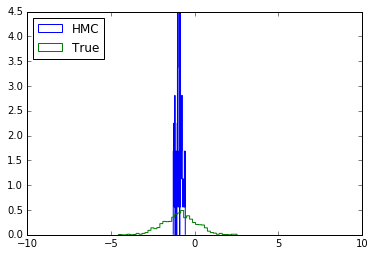

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

betas = stats.norm.rvs(true_beta, np.sqrt(1/tau), size=1000)
phis = stats.gamma.rvs(a=3,scale=1/2,size=1000)

plt.hist(results[round(4*M/5):(M-1),0], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(betas, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([-10,10]);
plt.legend(loc='upper left')
pass

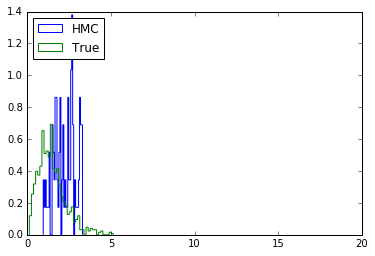

In [10]:
plt.hist(results[round(4*M/5):(M-1),1], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(phis, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,20]);
plt.legend(loc='upper left')
pass

In [ ]:
a = np.array([1,2])
b = np.array([2,5])
np.hstack([a,b])

In [ ]:
r0 = stats.norm.rvs(size=2)
print(np.exp(log_joint(y,x,theta0)-(1/2)*r0.dot(r0)))
np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta0)-(1/2)*r0.dot(r0)))

In [ ]:
r0.dot(r0)

In [ ]:
log_joint(y,x,theta0)

In [ ]:
np.mean(results[:,0])

In [ ]:
np.mean(results[:,1])